# Oracle and Python with cx_Oracle

**Note this is legacy code, see the notebook on using Oracle with Jupyter and oracledb library for reccomended code**

- An example of how to query Oracle from Python using cx_Oracle
- It show a way to integrate data from Oracle databases into Python's data analysis tools with [pandas](http://pandas.pydata.org/)
- Dependencies: needs an [Oracle client installation](http://www.oracle.com/technetwork/topics/linuxx86-64soft-092277.html) and [cx_Oracle](https://pypi.python.org/pypi/cx_Oracle)

## Setup and prerequisites

This is how you can setup an Oracle instance for testing using a docker image for oracle-free

Run oracle free on a container from gvenzl dockerhub repo  
see also https://github.com/gvenzl/oci-oracle-free  
`docker run -d --name mydb1 -e ORACLE_PASSWORD=oracle -p 1521:1521 gvenzl/oracle-free:latest`

Wait till the DB is started, it will take a few minutes  
check progress with:  
`docker logs -f mydb1`

Install the scott/tiger schema with the emp table in PDB freepdb1
```
docker exec -it mydb1 /bin/bash
sed -e s=SCOTT/tiger=SCOTT/tiger@freepdb1= -e s/OFF/ON/ /opt/oracle/product/23c/dbhomeFree/rdbms/admin/utlsampl.sql > script.sql
sqlplus system/oracle@freepdb1
@script.sql
```


Setup Oracle client and LD_LIBRARY_PATH

download from https://www.oracle.com/database/technologies/instant-client/linux-x86-64-downloads.html
and install locally
    
test connection using sqlplus

```
# cd /home/luca/oracle_client/instantclient_19_19 
cd <oracle_client_home_path> # edit as neeeded
export LD_LIBRARY_PATH=$PWD
./sqlplus scott/tiger@//localhost:1521/FREEPDB1
```

set LD_LIBRARY_PATH at the OS level and restart Jupyter

`export LD_LIBRARY_PATH=<oracle_client_home_path> # edit path as neeeded`

## Query Oracle from Python with cx_Oracle

In [17]:
# connect to Oracle using cx_Oracle
# !pip install cx_Oracle if needed

import cx_Oracle

db_user = 'scott'
db_connect_string = 'localhost:1521/freepdb1'
db_pass = 'tiger'

# this is the syntax for the connect string
# db_connect_string = 'dbserver:1521/orcl.mydomain.com'
#
# Normally you would not want to hardcode passwords in notebooks
# import getpass
# db_pass = getpass.getpass()

# Connect to Oracle using cx_Oracle
ora_conn = cx_Oracle.connect(user=db_user, password=db_pass, dsn=db_connect_string)


In [8]:
# open a cursor, run a query and fetch the results

cursor = ora_conn.cursor()
cursor.execute('select ename, sal from emp')
res = cursor.fetchall()
cursor.close()

print(res)

[('SMITH', 800.0), ('ALLEN', 1600.0), ('WARD', 1250.0), ('JONES', 2975.0), ('MARTIN', 1250.0), ('BLAKE', 2850.0), ('CLARK', 2450.0), ('SCOTT', 3500.0), ('KING', 5000.0), ('TURNER', 1500.0), ('ADAMS', 1100.0), ('JAMES', 950.0), ('FORD', 3000.0), ('MILLER', 1300.0)]


## cx_Oracle integration with Pandas

In [9]:
import pandas as pd

# query Oracle using ora_conn and put the result into a pandas Dataframe
df_ora = pd.read_sql('select * from emp', con=ora_conn)    
df_ora

/tmp/luca/ipykernel_18170/2659667783.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ora = pd.read_sql('select * from emp', con=ora_conn)


EMPNO   ENAME        JOB     MGR   HIREDATE     SAL    COMM  DEPTNO
0    7369   SMITH      CLERK  7902.0 1980-12-17   800.0     NaN      20
1    7499   ALLEN   SALESMAN  7698.0 1981-02-20  1600.0   300.0      30
2    7521    WARD   SALESMAN  7698.0 1981-02-22  1250.0   500.0      30
3    7566   JONES    MANAGER  7839.0 1981-04-02  2975.0     NaN      20
4    7654  MARTIN   SALESMAN  7698.0 1981-09-28  1250.0  1400.0      30
5    7698   BLAKE    MANAGER  7839.0 1981-05-01  2850.0     NaN      30
6    7782   CLARK    MANAGER  7839.0 1981-06-09  2450.0     NaN      10
7    7788   SCOTT    ANALYST  7566.0 1987-04-19  3500.0     NaN      20
8    7839    KING  PRESIDENT     NaN 1981-11-17  5000.0     NaN      10
9    7844  TURNER   SALESMAN  7698.0 1981-09-08  1500.0     0.0      30
10   7876   ADAMS      CLERK  7788.0 1987-05-23  1100.0     NaN      20
11   7900   JAMES      CLERK  7698.0 1981-12-03   950.0     NaN      30
12   7902    FORD    ANALYST  7566.0 1981-12-03  3000.0     NaN      20
13   7934  MILLER      CLERK  7782.0 1982-01-23  1300.0     NaN      10

## Use of bind variables

In [10]:
df_ora = pd.read_sql('select * from emp where empno=:myempno', params={"myempno":7839}, 
                     con=ora_conn) 
df_ora

/tmp/luca/ipykernel_18170/2156285171.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ora = pd.read_sql('select * from emp where empno=:myempno', params={"myempno":7839},


EMPNO ENAME        JOB   MGR   HIREDATE     SAL  COMM  DEPTNO
0   7839  KING  PRESIDENT  None 1981-11-17  5000.0  None      10

## Basic visualization

In [15]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')

/tmp/luca/ipykernel_18170/1955787221.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [18]:
df_ora = pd.read_sql('select ename "Name", sal "Salary" from emp', con=ora_conn)    

ora_conn.close()

/tmp/luca/ipykernel_18170/2884401902.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ora = pd.read_sql('select ename "Name", sal "Salary" from emp', con=ora_conn)


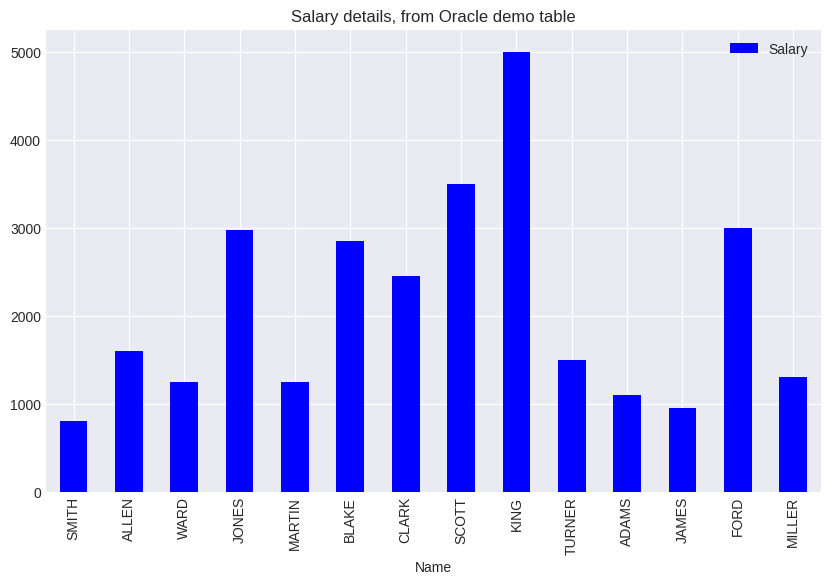

In [19]:
df_ora.plot(x='Name', y='Salary', title='Salary details, from Oracle demo table', 
            figsize=(10, 6), kind='bar', color='blue');

## Visualization of Oracle AWR data
- An example of visualization of a multidimensional data set: Oracle AWR repository
- See also <https://github.com/LucaCanali/PerfSheet.js> for more details on querying and plotting AWR data

In [7]:
ora_conn = cx_Oracle.connect('system/manager@dbserver:1521/orcl.mydomain.com')

df_ora = pd.read_sql('''
select cast(min(sn.begin_interval_time) over (partition by sn.dbid,sn.snap_id) as date) snap_time,
       sn.instance_number,
       ss.metric_name||' - '||ss.metric_unit metric_name_unit,
       ss.maxval,
       ss.average
from dba_hist_sysmetric_summary ss,
     dba_hist_snapshot sn
where
     sn.snap_id = ss.snap_id
     and sn.dbid = ss.dbid
     and sn.instance_number = ss.instance_number
     and sn.begin_interval_time between trunc(sysdate-2) and trunc(sysdate)
order by sn.snap_id''', con=ora_conn)   

ora_conn.close()

In [8]:
mydata=df_ora[(df_ora['METRIC_NAME_UNIT']=='Average Active Sessions - Active Sessions') & 
              (df_ora['INSTANCE_NUMBER']==1)][['SNAP_TIME','AVERAGE']]
mydata.columns=['Snapshot time','Average N# active sessions']
mydata

Snapshot time  Average N# active sessions
259   2016-06-04 00:00:10                    3.920560
902   2016-06-04 00:30:17                    3.707861
1519  2016-06-04 01:00:04                    2.855422
2185  2016-06-04 01:30:05                    2.227370
2831  2016-06-04 02:00:12                    2.152043
3535  2016-06-04 02:30:15                    2.131511
4133  2016-06-04 03:00:22                    2.018975
4706  2016-06-04 03:30:29                    2.009894
5317  2016-06-04 04:00:01                    2.822917
5993  2016-06-04 04:30:07                    4.023914
6593  2016-06-04 05:00:17                    1.870056
7244  2016-06-04 05:30:03                    2.047915
7887  2016-06-04 06:00:10                    1.771566
8527  2016-06-04 06:30:14                    2.138115
9099  2016-06-04 07:00:18                    1.940014
9757  2016-06-04 07:30:25                    2.223435
10364 2016-06-04 08:00:01                    2.915000
10996 2016-06-04 08:30:09                    3.200985
11651 2016-06-04 09:00:19                    3.156595
12277 2016-06-04 09:30:06                    3.237668
12919 2016-06-04 10:00:13                    2.934591
13525 2016-06-04 10:30:21                    3.115289
14157 2016-06-04 11:00:01                    3.081968
14949 2016-06-04 11:30:06                   10.115706
15455 2016-06-04 12:00:01                    2.953109
16057 2016-06-04 12:30:06                    2.176632
16715 2016-06-04 13:00:11                    1.817830
17323 2016-06-04 13:30:19                    2.219040
17887 2016-06-04 14:00:24                    1.802805
18577 2016-06-04 14:30:32                    2.416435
...                   ...                         ...
42071 2016-06-05 09:00:04                    3.404665
42703 2016-06-05 09:30:01                    4.374614
43335 2016-06-05 10:00:13                    3.245444
43967 2016-06-05 10:30:03                    4.842100
44599 2016-06-05 11:00:08                    1.982747
45231 2016-06-05 11:30:10                    2.144027
45863 2016-06-05 12:00:18                    1.863776
46495 2016-06-05 12:30:26                    1.899092
47127 2016-06-05 13:00:00                    2.812630
47759 2016-06-05 13:30:00                    3.277050
48391 2016-06-05 14:00:03                    4.312032
49023 2016-06-05 14:30:14                    2.036343
49655 2016-06-05 15:00:21                    1.911278
50287 2016-06-05 15:30:28                    1.817470
50919 2016-06-05 16:00:08                    1.589477
51551 2016-06-05 16:30:15                    2.065947
52183 2016-06-05 17:00:01                    1.675464
52815 2016-06-05 17:30:03                    1.989072
53447 2016-06-05 18:00:06                    1.855867
54079 2016-06-05 18:30:12                    1.998102
54711 2016-06-05 19:00:20                    1.664484
55343 2016-06-05 19:30:21                    1.940359
55975 2016-06-05 20:00:31                    1.641701
56607 2016-06-05 20:30:38                    2.334493
57239 2016-06-05 21:00:04                    1.961026
57871 2016-06-05 21:30:02                    2.049869
58503 2016-06-05 22:00:07                    1.708898
59135 2016-06-05 22:30:16                    2.065450
59767 2016-06-05 23:00:24                    1.725731
60399 2016-06-05 23:30:34                    2.183524

[96 rows x 2 columns]

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as md
plt.style.use('ggplot')

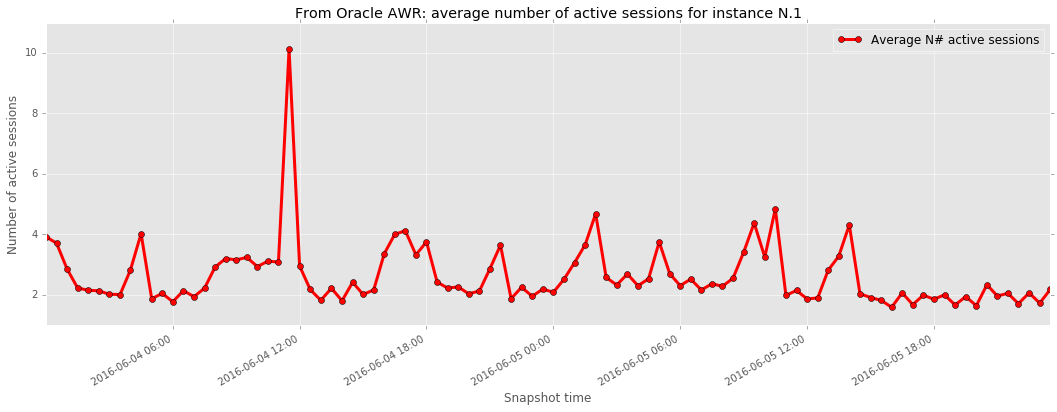

In [10]:
ax = mydata.plot(x='Snapshot time', y='Average N# active sessions', 
                 linewidth=3, style='ro-', figsize=(18, 6), 
                 title='From Oracle AWR: average number of active sessions for instance N.1')

xfmt = md.DateFormatter('%Y-%m-%d %H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylabel('Number of active sessions')

## Use of pivot and pandas

In [11]:
my_pivot=df_ora.pivot_table(index="SNAP_TIME", columns="METRIC_NAME_UNIT", aggfunc=sum, values="AVERAGE")

my_pivot

METRIC_NAME_UNIT     Active Parallel Sessions - Sessions  \
SNAP_TIME                                                  
2016-06-04 00:00:10                             0.200000   
2016-06-04 00:30:17                             0.033333   
2016-06-04 01:00:04                             0.100000   
2016-06-04 01:30:05                             0.200000   
2016-06-04 02:00:12                             0.133333   
2016-06-04 02:30:15                             0.466667   
2016-06-04 03:00:22                             0.433333   
2016-06-04 03:30:29                             0.200000   
2016-06-04 04:00:01                             0.066667   
2016-06-04 04:30:07                             0.133333   
2016-06-04 05:00:17                             0.133333   
2016-06-04 05:30:03                             0.000000   
2016-06-04 06:00:10                             0.000000   
2016-06-04 06:30:14                             0.000000   
2016-06-04 07:00:18                             0.000000   
2016-06-04 07:30:25                             0.000000   
2016-06-04 08:00:01                             0.000000   
2016-06-04 08:30:09                             0.000000   
2016-06-04 09:00:19                             0.266667   
2016-06-04 09:30:06                             0.000000   
2016-06-04 10:00:13                             0.133333   
2016-06-04 10:30:21                             0.000000   
2016-06-04 11:00:01                             0.033333   
2016-06-04 11:30:06                             0.000000   
2016-06-04 12:00:01                             0.133333   
2016-06-04 12:30:06                             0.100000   
2016-06-04 13:00:11                             0.133333   
2016-06-04 13:30:19                             0.000000   
2016-06-04 14:00:24                             0.000000   
2016-06-04 14:30:32                             0.000000   
...                                                  ...   
2016-06-05 09:00:04                             0.400000   
2016-06-05 09:30:01                             0.133333   
2016-06-05 10:00:13                             0.066667   
2016-06-05 10:30:03                             0.000000   
2016-06-05 11:00:08                             0.000000   
2016-06-05 11:30:10                             0.133333   
2016-06-05 12:00:18                             0.000000   
2016-06-05 12:30:26                             0.034483   
2016-06-05 13:00:00                             0.000000   
2016-06-05 13:30:00                             0.066667   
2016-06-05 14:00:03                             0.133333   
2016-06-05 14:30:14                             0.066667   
2016-06-05 15:00:21                             0.100000   
2016-06-05 15:30:28                             0.066667   
2016-06-05 16:00:08                             0.100000   
2016-06-05 16:30:15                             0.066667   
2016-06-05 17:00:01                             0.000000   
2016-06-05 17:30:03                             0.100000   
2016-06-05 18:00:06                             0.000000   
2016-06-05 18:30:12                             0.000000   
2016-06-05 19:00:20                             0.100000   
2016-06-05 19:30:21                             0.000000   
2016-06-05 20:00:31                             0.033333   
2016-06-05 20:30:38                             0.000000   
2016-06-05 21:00:04                             0.000000   
2016-06-05 21:30:02                             0.000000   
2016-06-05 22:00:07                             0.133333   
2016-06-05 22:30:16                             0.000000   
2016-06-05 23:00:24                             0.032258   
2016-06-05 23:30:34                             0.000000   

METRIC_NAME_UNIT     Active Serial Sessions - Sessions  \
SNAP_TIME                                                
2016-06-04 00:00:10                          30.133333   
2016-06-04 00:30:17                          

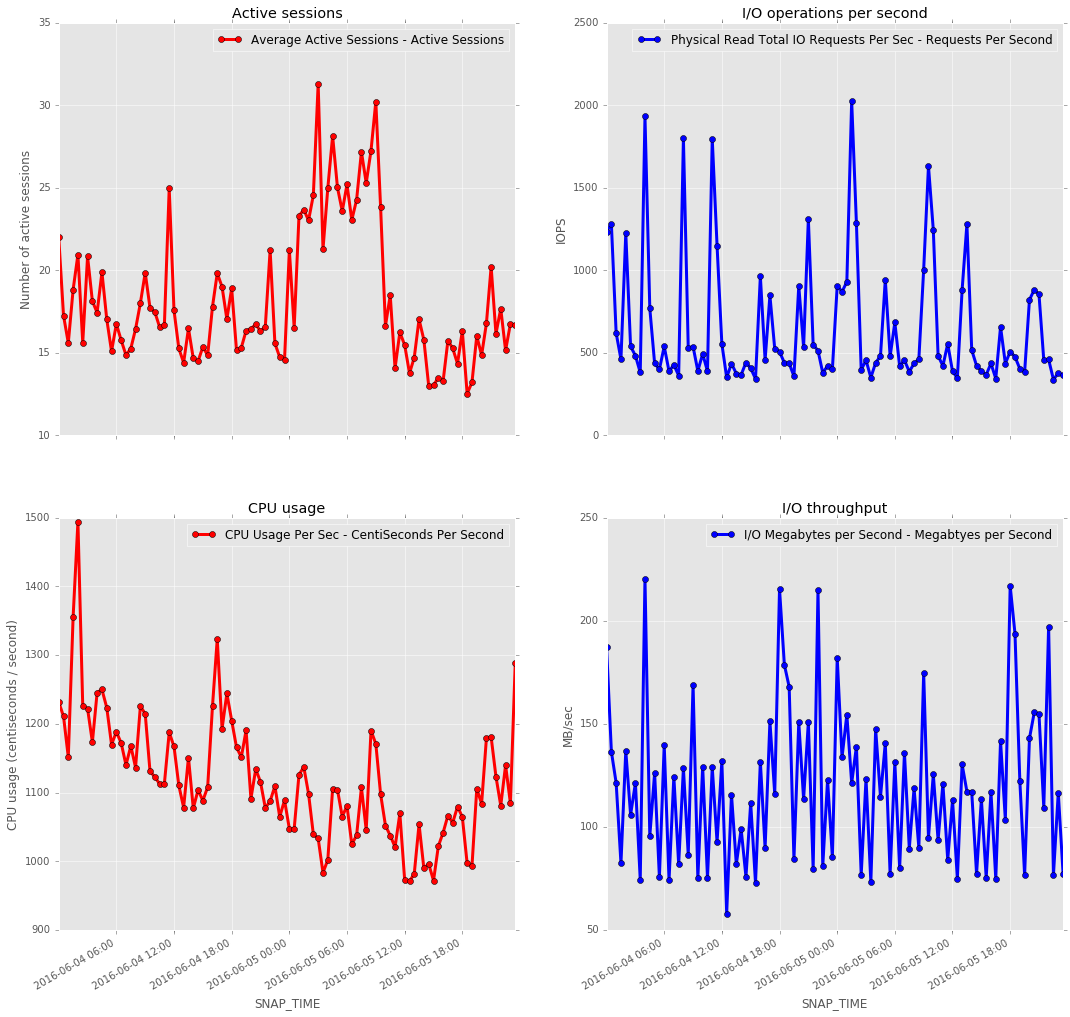

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18), sharex=True)
axes[0,0].xaxis.set_major_formatter(xfmt)

ax = my_pivot.plot(y='Average Active Sessions - Active Sessions', title='Active sessions', 
     ax=axes[0,0], linewidth=3, style='ro-').set_ylabel('Number of active sessions')
ax = my_pivot.plot(y='CPU Usage Per Sec - CentiSeconds Per Second', title='CPU usage',
     ax=axes[1,0], linewidth=3, style='ro-').set_ylabel('CPU usage (centiseconds / second)')
ax = my_pivot.plot(y='Physical Read Total IO Requests Per Sec - Requests Per Second', 
     title='I/O operations per second',
     ax=axes[0,1], linewidth=3, style='bo-').set_ylabel('IOPS')
ax = my_pivot.plot(y='I/O Megabytes per Second - Megabtyes per Second', title='I/O throughput',
                   ax=axes[1,1], linewidth=3, style='bo-').set_ylabel('MB/sec')
plt.show()